In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column

import matplotlib.pyplot as plt 
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20



Query the CRTS DR2 http://nesssi.cacr.caltech.edu/cgi-bin/getcssconedbid_release2.cgi  , against ID , RA 196.38756	DEC, -10.5554	rad 0.002 arcmin. Two objects are released, CSS_J130533.0-103319  (234 epochs) MLS_J130533.0-103319 (56 epochs).  

In [2]:
# read in the PG 1302 data....
data = Table.read('../raw_CRTS_data/PG1302-102_LC.csv', format='ascii')
data.sort('MJD')
y = data['Mag']
yerr = data['Magerr']
t = data['MJD']
outDir = '../data_products/Fig_6_data/'
#sliding_window_statistics(t,y,yerr, save_fig='No', fig_name='PG1302-102_LC.png', outDir = outDir)

In [3]:
import os 
import datetime
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_6_data',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('Saving todays work in %s'%outDir)

Saving todays work in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/


Calculate moving-average $\chi^{2}_{DOF}$  :



In [4]:
def calcChi2raw(y, yerr):
    """Compute simple reduced chi2  (mean-based) if more than 1 datapoints present
    chi2 = np.sum(((flux-meanFlux)**2.0) / (fluxErr ** 2.0)) / (N-1.0)
    """
    N = len(y)
    if N < 2:
        return np.nan
    else:
        chi2 = np.sum(((y-np.mean(y))/yerr)**2)
        return chi2/(N-1)
    
def calcWeightedMean(y,yerr):
    ''' Calculate the weighted mean '''
    N = len(y)
    if N == 1 : 
        return float(y)    
    elif N == 0 : 
        return np.nan
    else: 
        # weights = 1 / (yerr ** 2.0)  
        # wMean = np.sum(weights * flux) / np.sum(weights)
        return float(np.add.reduce(y / (yerr * yerr)) / np.add.reduce((1/yerr)*(1/yerr)))
    
N = len(y)
wMean = calcWeightedMean(y,yerr)
chi2dof  = (1 / (N-1.0)) * np.sum(((y- wMean)/yerr)**2)



In [56]:
% matplotlib inline 

def sliding_window_statistics(t,y,yerr, window_width=500, offset_factor = 0.5, save_fig=None, fig_name=None, 
                              return_results=None, outDir = None, window_error = 'combined'):
    '''
    A simple function to calculate sliding window stats, and plot them. By default, no dictionary 
    with results is returned. 
    
    Required parameters:
    ---------------------
    t : the obs time 
    y : the flux measurement
    yerr : the flux error 
    
    Optional parameters:  
    ---------------------
    window_width : the width of the sliding window (in days ), default is 500 days 
    offset_factor : it sets by how much shall we offset the left edge of the first window 
                    with respect to the earliest datapoint : the shift = offset_factor * window_width. 
                    Default is 0.5 
    save_fig : shall we save the plot as png?  Default : None
    fig_name : a name of the figure. Expect a full name, including extension. Default : None 
    return_results :  return the dictionary with sliding window statistics  ?  Default : None 
    
    Method: 
    --------
    By sliding window we mean  a span of data between  t1 and t2,  such that 
    t1 < t < t2 . We calculate in the store dictionary :
    - chi2dof_window :  chi2 per degree of freedom based on the weighted mean
    and provided raw photometric errors,   
    - N_pts_window : the number of points contained in the window 
    - t_center_window : the middle of the window (note : this is not  mean(t),  but (t2-t1) / 2)
    - t_window_mean : just for comparison, the mean t of the window (data based )
    - wMean_window : the weighted mean of the flux measurement (y)
    
    Returns:
    ---------
    store{} : (optional)  a dictionary (if return_results != None)
    
    '''
    
    
    # set up window size , sliding step..... 
    window_width = 500 # days 
    offset = offset_factor * window_width
    t0 = min(t) - offset

    window_slide_step_size=  5 #  days 
    window_frame_start = np.arange(t0, max(t), window_slide_step_size)
    window_frame_end = window_frame_start + window_width

    # calculate the  sliding window statistics 
    N_windows = len(window_frame_start)

    store = {'N_pts_window':np.zeros(N_windows), 't_center_window':np.zeros(N_windows), 
          't_window_mean':np.zeros(N_windows), 'wMean_window':np.zeros(N_windows),
            'chi2dof_window':np.zeros(N_windows), 'errMedian_window':np.zeros(N_windows),
            'errCombined_window':np.zeros(N_windows)}

    for i in range(N_windows) :
        mask_in_window = ( window_frame_start[i] < t)  * (t < window_frame_end[i])
        t_window = t[mask_in_window]
        y_window = y[mask_in_window]
        yerr_window = yerr[mask_in_window]

        N_pts_window = float(len(t_window))
        store['N_pts_window'][i] = N_pts_window
        store['t_center_window'][i] = (window_frame_end[i] + window_frame_start[i]) / 2.0
        store['t_window_mean'][i] = np.mean(t_window)
        
        store['errMedian_window'][i] = np.median(yerr_window)
        err_weights = 1 / (yerr_window**2.0)
        store['errCombined_window'][i] = 1 / np.sqrt(np.sum(err_weights))
        wMean_window = calcWeightedMean(y_window, err_weights)
        store['wMean_window'][i] = wMean_window
        
        if N_pts_window > 1 : 
            store['chi2dof_window'][i] = (1 / (N_pts_window-1.0)) * np.sum(((y_window- wMean_window)/yerr_window)**2)
        else  : 
            store['chi2dof_window'][i] = np.nan
            
    print('Using %d windows of width %d days each , with the window sliding step of  %d days'%(N_windows, 
                                                            window_width, window_slide_step_size ) )
    # plot  : 
    # ax[0] : the lightcurve
    # ax[1] : count of points per window 
    # ax[2] : t_center_window vs wMean_window
    # ax[3] : chi2dof_window
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=( 10,12 ))   # (x_size , y_size)
    ax = dict()
    number_of_rows = 6
    number_of_columns = 1
    gs = gridspec.GridSpec(number_of_rows,  number_of_columns)
    ax[0] = plt.subplot(gs[:2, :])  # span all rows but the last one (bottom), and first 5 col
    ax[1] = plt.subplot(gs[2, :])  # span all rows but the last one (bottom), and last 5 cols
    ax[2] = plt.subplot(gs[3, :])  # span both rows, only second col
    ax[3] = plt.subplot(gs[4, :])
    ax[4] = plt.subplot(gs[5, :])
    
    fig.subplots_adjust(hspace=0.4)

    # lightcurve
    ax[0].scatter(t,y, lw=0, s=20, c='red')
    ax[0].errorbar(t, y, yerr, ls='None', alpha=0.5) 
    ax[0].set_ylabel('mag')
    size = 10

    # show an example window size...
    ax[0].axvline(window_frame_start[0], ls='--', color='magenta',lw=2)
    ax[0].axvline(window_frame_end[0],ls='--', color='magenta', lw=2)

    # overplot the mean....
    ax[0].scatter(store['t_center_window'], store['wMean_window'], s=size, lw=0, color='green')

    # count of points per window
    #ax[1].plot(store['t_center_window'],store['N_pts_window'], ls = 'steps')
    ax[1].scatter(store['t_center_window'],store['N_pts_window'], s=size, lw=0)
    ax[1].set_ylabel('N')

    # t_center_window vs wMean_window
    ax[2].scatter(store['t_center_window'], store['wMean_window'], s=size, lw=0, color='green')
    if window_error == 'median' : 
        ax[2].errorbar(store['t_center_window'], store['wMean_window'], store['errMedian_window'], 
                       ls='None', alpha=0.5)
    else :
        ax[2].errorbar(store['t_center_window'], store['wMean_window'], store['errCombined_window'], 
                       ls='None', alpha=0.3)
        #print('Using combined error from combined weights (see CRTS paper,  eq.4)')
        
    ax[2].set_ylabel(r'$\langle mag \rangle_{w}$')

    # chi2dof_window
    ax[3].scatter(store['t_center_window'], store['chi2dof_window'], s=size, lw=0)
    ax[3].set_ylabel(r'$\chi^{2}_{DOF}$')

    # plot errors per window ( the combined errors... )
    if window_error == 'median' : 
        ax[4].scatter(store['t_center_window'], store['errMedian_window'] ,  s=size, lw=0, alpha=0.5)
    else :
        ax[4].scatter(store['t_center_window'], store['errCombined_window'], s=size, lw=0, alpha=0.3)
        #print('Using combined error from combined weights (see CRTS paper,  eq.4)')
    ax[4].set_ylabel(r'$\sigma_{\langle mag \rangle_{w}}$')
    ax[4].grid()
    
    # move xlims of each plot so that they all start in the same place...
    xlim = ax[0].get_xlim()
    for i in range(1,len(ax)):
        ax[i].set_xlim(xlim)

    # remove edge xticks
    for i in range(len(ax)):
        xticks = ax[i].get_xticks()
        ax[i].set_xticks(xticks[1:-1])

    # make second axis start at 0 
    ax[1].set_ylim(0,)

    # make second axis ticks more rare 
    yticks = ax[1].get_yticks()
    ax[1].set_yticks(yticks[::2])
    
    # make third axis ticks more rare 
    yticks = ax[2].get_yticks()
    ax[2].set_yticks(yticks[::2])
    
    # make last axis start at 0 
    #ax[3].set_ylim(0,)

    # make last axis yticks more rare
    yticks = ax[3].get_yticks()
    ax[3].set_yticks(yticks[::2])
    
    
    # set ylims to be more in touch with the data ....
    ax[4].set_ylim(0.8*min(store['errCombined_window']), 1.2 *max(store['errCombined_window']))
    print('sigma min %f, max %f'%(min(store['errCombined_window']), max(store['errCombined_window'])))
    
    # make last last axis yticks more rare
    yticks = ax[4].get_yticks()
    ax[4].set_yticks(yticks[::2])


    
    # add horizontal lines to chi2dof plot : 
    ax[3].grid()
    
    # Save the figure...
    if save_fig is not None  : 
        if outDir is None :
            outDir = '../data_products/Fig_6_data/'
        if fig_name is None : 
            fname='PG1302-102'+'_win_'+str(window_width)+'_days.png'
        else:
            fname = fig_name
        plt.tight_layout()
        plt.savefig(outDir+fname)
        print('Saved this plot as %s'%(outDir+fname))
        plt.clf()
        plt.close(fig)
    # if desired, return the output
    if return_results is not None  :
        return store 

Using 640 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.005911, max 0.030000


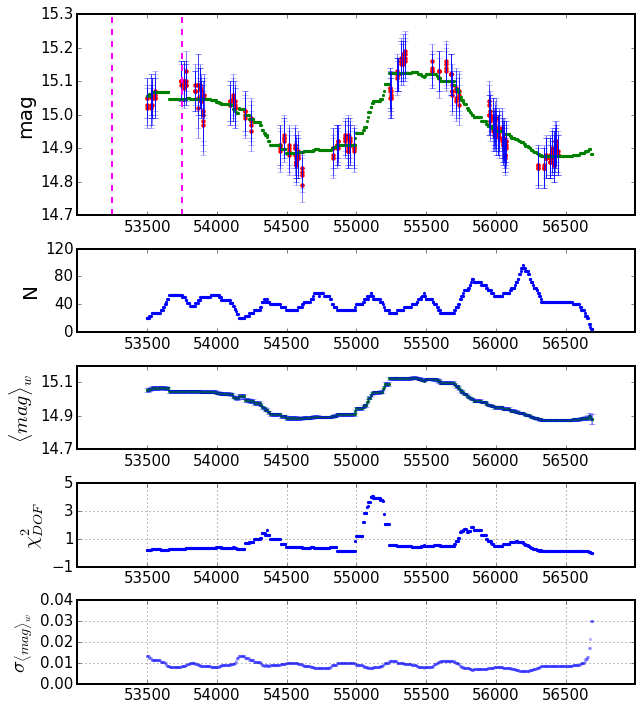

In [57]:
sliding_window_statistics(t,y,yerr, save_fig=None, outDir=outDir, window_error = 'else')

## Apply to a few bright and faint QSO and stars : 

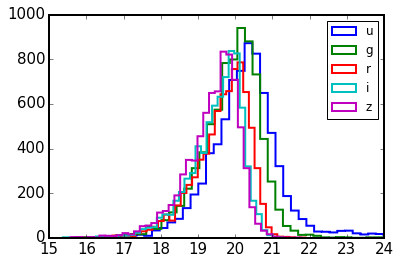

In [23]:
## Read in few quasars : choose one bright, well-sampled QSO, and one faint, same for stars . 

# Load the cross-matched CRTS-SDSS summary table : 
address = '../data_products/CRTS_SDSS_combined_QSO_catalog.dat'
sdss_crts = Table.read(address, format='ascii')

# show all colnames
np.ravel(sdss_crts.colnames)

# plot histogram of brightness distribution
for f in 'ugriz' : 
    plt.hist(sdss_crts[f][(sdss_crts[f]>10)*(sdss_crts[f]<24)], histtype='step', lw=2, label=f, bins=40)
plt.legend()

In [24]:
# Choose two QSO classes : bright and faint:  

bright_QSO = sdss_crts[(sdss_crts['g'] > 15)*( sdss_crts['g'] < 16)]
# 235156.12-010913.3   has 404 points... 

faint_QSO = sdss_crts[(sdss_crts['g']>20)*(sdss_crts['g']<21)]
faint_QSO.sort('raw_lc_length')
faint_long_QSO = faint_QSO[-10:-1]

In [25]:
faint_long_QSO

raw_timespan_obs,raw_mean_err,raw_lc_length,raw_mean_mag,CRTS_name,proc_mean_N_day,proc_lc_length,proc_mean_mag,proc_mjd_span,proc_mean_err,proc_median_dt,ra_CRTS,dec_CRTS,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,match_angle_arcsec
float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3025.83301,0.148161209068,397.0,18.742720403,231121.09+005133.8,4.09278350515,97.0,18.6999061856,3025.8092,0.0741762886598,15.99885,347.837875,0.859388888889,475129,347.837921,0.859398,75720,-22.443,-23.133,0.4832,8.776,45.249,20.751,20.364,20.142,19.602,19.227,0.215,0.168798787984
3002.94245,0.175125628141,398.0,19.4244974874,235249.39-000629.4,3.79047619048,105.0,19.3268761905,3002.9245,0.0990952380952,11.03495,358.205791667,-0.108166666667,3958962,358.205811,-0.108186,77157,-23.013,-23.242,0.631,0.0,45.261,20.615,20.106,20.0,19.66,19.645,0.165,0.0984291762447
2999.89596,0.201122194514,401.0,19.6618952618,234629.98-010825.5,3.58035714286,112.0,19.6055464286,2999.8765,0.132603571429,12.0144,356.624916667,-1.14041666667,3985033,356.624908,-1.140436,76926,-24.504,-25.082,1.2051,8.151,45.899,20.279,20.181,19.805,19.741,19.689,0.179,0.0762706653404
3002.94374,0.208756097561,410.0,19.7031707317,234648.39-010116.3,3.38842975207,121.0,19.6757710744,3002.9246,0.150010743802,12.00615,356.701625,-1.02119444444,3882125,356.70163,-1.021222,76935,-22.024,-22.715,0.4235,0.0,0.0,20.659,20.334,19.954,19.687,19.446,0.176,0.100819328951
2920.01124,0.223547619048,420.0,19.4243809524,033931.15+011449.9,4.77272727273,88.0,19.2450477273,2919.9923,0.103611363636,13.1192,54.8797916667,1.24719444444,3748997,54.879829,1.247217,8268,-24.885,-25.527,1.409,8.741,45.983,20.609,20.456,20.199,19.923,19.728,0.651,0.15699758668
3002.94374,0.195141509434,424.0,19.5285613208,234509.42-005506.7,3.5041322314,121.0,19.4728768595,3002.9246,0.135988429752,12.0155,356.28925,-0.918527777778,4004892,356.289276,-0.918536,76889,-24.588,-25.002,1.359,9.037,46.0,20.294,20.383,20.033,19.949,20.124,0.195,0.0981573663458
2999.92262,0.185940366972,436.0,19.370206422,234033.70-005636.9,3.69491525424,118.0,19.2867576271,2999.9023,0.11096779661,11.9609,355.140416667,-0.943583333333,3892324,355.140442,-0.943589,76719,-27.326,-27.994,3.6502,9.528,47.078,25.436,20.682,19.571,19.448,19.522,0.178,0.0934416628874
2997.8335,0.194336283186,452.0,19.4192477876,233155.01-011515.0,3.64516129032,124.0,19.3564524194,2997.8146,0.113992741935,10.9418,352.979208333,-1.25416666667,314358,352.979248,-1.254173,76413,-23.65,-24.173,0.8749,8.674,45.708,20.555,20.019,19.817,19.833,19.673,0.203,0.144574931634
2890.16152,0.167833698031,457.0,19.6564332604,235225.61+002337.9,4.91397849462,93.0,19.4516086022,2890.1431,0.102159139785,12.3851,358.106708333,0.393861111111,3971396,358.10672,0.393876,77145,-25.222,-26.138,1.8437,0.0,46.094,20.824,20.781,20.534,20.019,20.188,0.167,0.0680946152988


In [26]:
# Read in stars ...
address = '../data_products/CRTS_SDSS_combined_stars_catalog.dat'
stars = Table.read(address, format='ascii') 

# display their colnames
print(np.ravel(stars.colnames))

['raw_mjd_span' 'raw_mean_mag' 'raw_mean_err' 'CRTS_name' 'raw_lc_length'
 'proc_mean_N_day' 'proc_mean_err' 'proc_lc_length' 'proc_mean_mag'
 'proc_mjd_span' 'ra_1' 'dec_1' 'calib_fla' 'ra_2' 'dec_2' 'raRMS' 'decRMS'
 'nEpochs' 'AR_val' 'u_Nobs' 'u_mMed' 'u_mMean' 'u_mErr' 'u_rms_scatt'
 'u_chi2' 'g_Nobs' 'g_mMed' 'g_mMean' 'g_mErr' 'g_rms_scatt' 'g_chi2'
 'r_Nobs' 'r_mMed' 'r_mMean' 'r_mErr' 'r_rms_scatt' 'r_chi2' 'i_Nobs'
 'i_mMed' 'i_mMean' 'i_mErr' 'i_rms_scatt' 'i_chi2' 'z_Nobs' 'z_mMed'
 'z_mMean' 'z_mErr' 'z_rms_scatt' 'z_chi2']


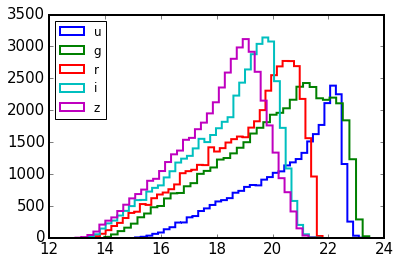

In [27]:
# plot histogram of brightness distribution
for l in 'ugriz' : 
    f = l+'_mMed'
    plt.hist(stars[f][(stars[f]>10)*(stars[f]<24)], histtype='step', lw=2, label=l, bins=40)
plt.legend(loc='upper left')

In [28]:
# Choose few CRTS stars....

bright_stars = stars[(stars['g_mMed'] < 16) * (stars['g_mMed'] > 15 ) ]
bright_stars.sort('raw_lc_length')  # sorting sorts from lowest to highest 
bright_long_stars  = bright_stars[::-1][:10]  # choose the 10 longest 

faint_stars = stars[(stars['g_mMed'] > 20)*(stars['g_mMed'] <  21)]
faint_stars.sort('raw_lc_length')
faint_long_stars = faint_stars[::-1][:10]

In [29]:
# Find stars around the same coordinates as a given QSO ... 

#  PG1302-102 has coords outside of S82 footprint, but 
# I can consider another QSO, and pick stars that are in the same region of the sky....

# Erik Tollerud's tutorial about using astropy.coordinates to match catalogs. etc 
# http://www.astropy.org/astropy-tutorials/Coordinates.html

# The documentation for the newest astropy : 
#http://astropy.readthedocs.io/en/latest/coordinates/matchsep.html


#idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, 1*u.deg)



In [30]:
qsos = bright_QSO # faint_long_QSO # bright_QSO # faint_long_QSO  # bright_QSO # faint_long_QSO  # or 

coo_crts_qso = SkyCoord(qsos['ra']*u.deg, qsos['dec']*u.deg)
coo_crts_stars =  SkyCoord(stars['ra_1']*u.deg, stars['dec_1']*u.deg)

for i in range(len(qsos)) : 
    scalar_single_qso_coords  =  coo_crts_qso[i]
    d2d = scalar_single_qso_coords.separation(coo_crts_stars)  

    search_radius_arcmin = 10 
    catalogmsk = d2d < search_radius_arcmin*u.arcmin
    print('There are %d CRTS stars within %d arcmin from the chosen QSO'%(np.sum(catalogmsk), search_radius_arcmin))
    nearby_crts_stars_coords = coo_crts_stars[catalogmsk]
    nearby_crts_stars = stars[catalogmsk]

    save = stars[catalogmsk]
    
   
    dist2d =  Column(data=d2d[catalogmsk], name='sep2d_deg' )

    a = np.empty(np.sum(catalogmsk), dtype='str') 
    b = np.array([row + qsos['CRTS_name'][i]  for row in a ])
    center_qso = Column(data = b, name  ='center_CRTS_QSO')

    save.add_columns([dist2d, center_qso])
    
    archfile = 'qso_'+qsos['CRTS_name'][i] + '_stars_within_'+str(search_radius_arcmin)+'-arcmin.txt'
    address = '../data_products/'+archfile
    save.write(address, format='ascii', overwrite=True)
    print('Catalog of stars nearby to %s is saved as %s'%(qsos['CRTS_name'][i], address) )

There are 8 CRTS stars within 10 arcmin from the chosen QSO
Catalog of stars nearby to 031027.82-004950.7 is saved as ../data_products/qso_031027.82-004950.7_stars_within_10-arcmin.txt
There are 9 CRTS stars within 10 arcmin from the chosen QSO
Catalog of stars nearby to 235156.12-010913.3 is saved as ../data_products/qso_235156.12-010913.3_stars_within_10-arcmin.txt


## Plotting ... 

### 1) Quasars... 

In [58]:
# FAINT  QSO 

for i in range(len(faint_long_QSO)):
    lc_dir = '../raw_LC_CRTS/QSO_CRTS/' 
    qso_name = faint_long_QSO['CRTS_name'][i]
    address = lc_dir + qso_name+'.dat'
    data = Table.read(address, format='ascii')
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='qso_faint_'+qso_name+'.png', outDir = outDir)


Using 656 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.012186, max 0.077851
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_faint_231121.09+005133.8.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.013029, max 0.050000
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_faint_235249.39-000629.4.png
Using 650 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.013519, max 0.055961
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_faint_234629.98-010825.5.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.014891, max 0.051121
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_faint_234648.39-010116.3.png
Using 635 windows of width 5

In [59]:
# BRIGHT  QSO 
for i in range(len(bright_QSO)):
    lc_dir = '../raw_LC_CRTS/QSO_CRTS/' 
    qso_name = bright_QSO['CRTS_name'][i]
    address = lc_dir + qso_name+'.dat'
    data = Table.read(address, format='ascii')
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')
    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                          save_fig='Yes', fig_name='qso_bright_'+qso_name+'.png', outDir = outDir)

Using 638 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.006672, max 0.030000
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_bright_031027.82-004950.7.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.005419, max 0.025000
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_bright_235156.12-010913.3.png


### 2) Stars... 

In [21]:
#nearby_crts_stars

In [61]:
#
# PROXIMITY...
#
# Choose stars within a certain radius from a given QSO ...

# Here we first choose quasar based on magnitude and length of lightcurve: 
# we choose the brightest quasar for bright_QSO (there are only 2 that are within the selected brightness cutoff)
# we choose the faintest quasars for faint_long_QSO, and take only 10 that have longest CRTS raw lightcurves 

# for each quasar in a given set we find CRTS standard stars from SDSS S82 standard stars catalog that 
# are within 10 arcminutes. 

# we plot the sliding window statistic for each nearby star, which are bright and faint.  

# run only for two faint qso that I'm sending to Zeljko....

qsos = bright_QSO # faint_long_QSO[-2:] # bright_QSO # faint_long_QSO  #  bright_QSO # faint_long_QSO # bright_QSO
brightness_class = 'bright' # faint' # faint' # 'bright', 

for j in range(len(qsos)):
    archfile = 'qso_'+qsos['CRTS_name'][j] + '_stars_within_'+str(search_radius_arcmin)+'-arcmin.txt'
    address = '../data_products/'+archfile
    nearby_crts_stars = Table.read(address, format='ascii')
    tab = nearby_crts_stars

    for i in range(len(tab)):
        lc_dir = '../raw_LC_CRTS/stars/' 
        name = str(tab['CRTS_name'][i]) # choose lightcurve from LC catalog 
        address = lc_dir + name+'.dat'
        data = Table.read(address, format='ascii') # read in the lightcurve 
        data.rename_column('col1', 'MJD')
        data.rename_column('col2', 'Mag')
        data.rename_column('col3', 'Magerr')
        data.sort('MJD')
        sep2d_deg = tab['sep2d_deg'][i]
        sep2d_arcmin = sep2d_deg * 60 
        sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                                  save_fig='Yes', fig_name='qso_'+brightness_class+'_'+qsos['CRTS_name'][j]  +\
                                  '_star_'+str(np.mean(data['Mag']))[:5]+'-mag_'+name+'_within_' +\
                                  str(sep2d_arcmin)[:5]+'_arcmin.png', outDir = outDir)



Using 638 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.008600, max 0.040000
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_bright_031027.82-004950.7_star_16.93-mag_247468_within_7.917_arcmin.png
Using 638 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.007561, max 0.035000
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_bright_031027.82-004950.7_star_16.49-mag_247534_within_5.779_arcmin.png
Using 638 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.032032, max 0.151905
Saved this plot as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-08/qso_bright_031027.82-004950.7_star_19.94-mag_247659_within_8.222_arcmin.png
Using 638 windows of width 500 days each , with the window sliding step of  5 days
sigma min 0.028257, max 0.140475
Saved this plot as /Users/

In [22]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (500,-1))

In [ ]:
# Read in stellar lightcurve...
# BRIGHT STARS 

tab =  bright_long_stars
for i in range(len(tab)):
    lc_dir = '../raw_LC_CRTS/stars/' 
    name = str(tab['CRTS_name'][i]) # choose lightcurve from LC catalog 
    address = lc_dir + name+'.dat'
    data = Table.read(address, format='ascii') # read in the lightcurve 
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='star_bright_'+name+'.png')


    

In [ ]:
# Read in stellar lightcurve...
# FAINT STARS

tab =  faint_long_stars
for i in range(len(tab)):
    lc_dir = '../raw_LC_CRTS/stars/' 
    name = str(tab['CRTS_name'][i]) # choose lightcurve from LC catalog 
    address = lc_dir + name+'.dat'
    data = Table.read(address, format='ascii') # read in the lightcurve 
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='star_faint_'+name+'.png', outDir = outDir)


    